In [3]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage
from dotenv import load_dotenv
import os
import getpass

load_dotenv()

True

In [2]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model = "gemini-2.5-flash-preview-05-20")

In [4]:
class AgentState(TypedDict):
  messages: list[HumanMessage | AIMessage]

In [5]:
def chat_node(state:AgentState) -> AgentState:
  response = llm.invoke(state['messages'])
  state['messages'].append(AIMessage(content=response.content))
  print(f"AI: {response.content}\n")
  return state

In [6]:
graph = StateGraph(state_schema=AgentState)
graph.add_node("chatbot",chat_node)
graph.add_edge(START,"chatbot")
graph.add_edge("chatbot",END)

agent = graph.compile()

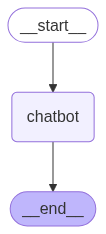

In [7]:
agent

In [7]:
conversation_history = []

In [ ]:
current_speaker = None
current_content = []

with open("conversation_history.txt", "r") as f:
    for line in f:
        line = line.strip()
        if line.startswith("You: "):
            # Save the previous message before starting a new one
            if current_speaker == "You" and current_content:
                conversation_history.append(HumanMessage(content="\n".join(current_content)))
            elif current_speaker == "AI" and current_content:
                conversation_history.append(AIMessage(content="\n".join(current_content)))
            
            current_speaker = "You"
            current_content = [line[len("You: "):]]
        
        elif line.startswith("AI: "):
            if current_speaker == "You" and current_content:
                conversation_history.append(HumanMessage(content="\n".join(current_content)))
            elif current_speaker == "AI" and current_content:
                conversation_history.append(AIMessage(content="\n".join(current_content)))
            
            current_speaker = "AI"
            current_content = [line[len("AI: "):]]
        
        else:
            # Line is part of the current message
            current_content.append(line)

# Don't forget to append the last message
if current_speaker == "You" and current_content:
    conversation_history.append(HumanMessage(content="\n".join(current_content)))
elif current_speaker == "AI" and current_content:
    conversation_history.append(AIMessage(content="\n".join(current_content)))

In [9]:
conversation_history

[HumanMessage(content='Hi, I am Shorya', additional_kwargs={}, response_metadata={}),
 AIMessage(content="Hello Shorya! Nice to meet you.\n\nI'm an AI assistant. How can I help you today?", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Hmm, I am learning langgraph, using gemini as an LLM client, how can i add an systemt prompt to it?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='That\'s a great question, and it\'s a common pattern when building agents with LangGraph!\n\nWhen using Gemini via LangChain (which LangGraph leverages), you add a system prompt by including a `SystemMessage` object at the beginning of the list of messages you pass to the LLM.\n\nHere\'s how you can do it within a LangGraph node:\n\n### Core Concept: The `SystemMessage`\n\nLangChain\'s message types (which Gemini understands) include:\n*   `HumanMessage`: For user input.\n*   `AIMessage`: For AI responses.\n*   `SystemMessage`: For instructions, persona, or context tha

In [14]:
user_input = input("Enter your message: ")

while user_input.lower() != "exit":
    conversation_history.append(HumanMessage(content=user_input))
    
    print(f"You: {user_input}")
    response = agent.invoke({"messages":conversation_history})
    
    conversation_history = response['messages']
    
    user_input = input("Enter your message: ")

You: Hi, I am Shorya
AI: Hello Shorya! Nice to meet you.

I'm an AI assistant. How can I help you today?

You: Hmm, I am learning langgraph, using gemini as an LLM client, how can i add an systemt prompt to it?
AI: That's a great question, and it's a common pattern when building agents with LangGraph!

When using Gemini via LangChain (which LangGraph leverages), you add a system prompt by including a `SystemMessage` object at the beginning of the list of messages you pass to the LLM.

Here's how you can do it within a LangGraph node:

### Core Concept: The `SystemMessage`

LangChain's message types (which Gemini understands) include:
*   `HumanMessage`: For user input.
*   `AIMessage`: For AI responses.
*   `SystemMessage`: For instructions, persona, or context that guides the AI's behavior.

You pass a list of these messages to your LLM. The `SystemMessage` should typically be the first message in the list.

### Example Implementation

Let's set up a simple LangGraph with a node that 

In [15]:
with open("conversation_history.txt", "w") as f:
    for message in conversation_history:
        if isinstance(message, HumanMessage):
            f.write(f"You: {message.content}\n")
        elif isinstance(message, AIMessage):
            f.write(f"AI: {message.content}\n")